# Annotating the heart atlas
Annotate a subsampled version of the heart cell atlas {cite:p}`litvivnukova2020cells`. Head to [https://www.heartcellatlas.org/](https://www.heartcellatlas.org/) for more information on this dataset. 

Running this notebook will automatically download the data from figshare. 

## Preliminaries

### Import packages & data

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from cell_annotator import CellAnnotator, ObsBeautifier
from cell_annotator.utils import _shuffle_cluster_key_categories_within_sample

Load a subsampled version of the heart cell atlas {cite:p}`litvivnukova2020cells`. This dataset has been obtained using [scvi.data.heart_cell_atlas_subsampled()](https://docs.scvi-tools.org/en/stable/api/reference/scvi.data.heart_cell_atlas_subsampled.html#). We computed an embedding with scVI to visualize the data {cite:p}`lopez2018deep`. 

In [2]:
adata = sc.read("data/heart_atlas.h5ad", backup_url="https://figshare.com/ndownloader/files/51994787")

adata

AnnData object with n_obs × n_vars = 18641 × 1200
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_source_colors', 'cell_type_colors', 'donor_colors', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

### Preprocess the data

Create numerical cell type labels to be used for annotation and a shuffled version thereof. 

In [3]:
adata.obs["leiden"] = adata.obs["cell_type"].copy()
adata.obs["leiden"] = adata.obs["leiden"].cat.rename_categories(
    {cat: str(i) for i, cat in enumerate(adata.obs["cell_type"].cat.categories)}
)

adata = _shuffle_cluster_key_categories_within_sample(adata, sample_key="cell_source", key_added="leiden_shuffled")

Visualize

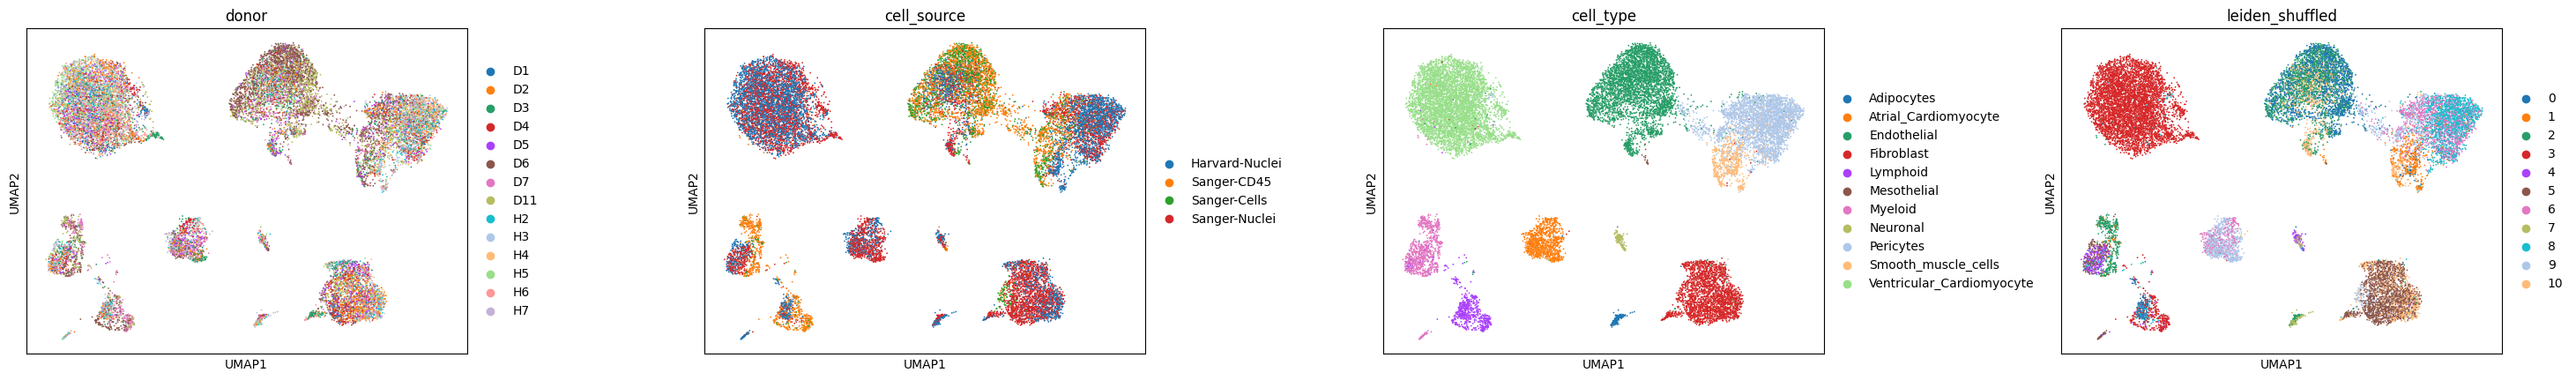

In [4]:
sc.pl.embedding(
    adata, basis="umap", color=["donor", "cell_source", "cell_type", "leiden_shuffled"], wspace=0.4, ncols=5
)

We're using the `cell_source` annotation to denote different samples, and we randomly shuffled the order of cluster labels within each sample to resemble a realistic scenario, in which we're given a dataset with several samples, with independent clustering per sample (i.e., pre-integration). 

## Query cell type labels per sample

In this notebook, we will demonstrate the simplest usage of this package, which is just a single method call. If you want to have more control over what's happening behind the scences, to check model outputs at intermediate steps or to infuse prior knowledge, head over to our more advanced tutorial: {doc}`200_human_bmmcs`. 

In [5]:
cell_ann = CellAnnotator(
    adata, species="human", tissue="heart", cluster_key="leiden_shuffled", sample_key="cell_source", model="gpt-4.1"
)
cell_ann

INFO     ✅ OPENAI API key is available                                                                            
INFO     Initializing `4` SampleAnnotator objects(s).                                                              


🧬 CellAnnotator
📋 Species: human
🔬 Tissue: heart
⏳ Stage: adult
🔗 Cluster key: leiden_shuffled
🔬 Sample key: cell_source

🤖 Provider: openai
🧠 Model: gpt-4.1

🔋 Status: ❌ Not working

📊 Samples: 4
🏷️  Sample IDs: 'Sanger-CD45', 'Sanger-Nuclei', 'Sanger-Cells', 'Harvard-Nuclei'

:::{note} A word on model choice:

For each LLM providor (like OpenAI, Gemini, etc.), there's a default model which will be used if you don't specify one explicitly. Such a default model is enough for simpler use cases or to experiment with the package. Running this notebook with the default model will cost you less than 0.01 USD. Here, we're using a more powerful model, to demonstrate the full strength of the package. Running with this more powerful model will incur some small cost, which depends on the model, the LLM provider, and your usage tier (it's usually far less than 1 USD). 
:::

In [6]:
cell_ann.annotate_clusters()

INFO     Querying cell types.                                                                                      
INFO     Writing expected cell types to `self.expected_cell_types`                                                 
INFO     Querying cell type markers.                                                                               
INFO     Writing expected marker genes to `self.expected_marker_genes`.                                            
INFO     Filtering marker genes to only include those present in adata.var_names.                                  
INFO     Filtered 8 marker genes and removed 0 cell types with no marker genes left after filtering.               
INFO     Iterating over samples to annotate clusters.                                                              


  0%|          | 0/4 [00:00<?, ?it/s]

INFO     Querying cell-type label de-duplication.                                                                  
INFO     Removed 3/19 cell types.                                                                                  
INFO     Iterating over samples to harmonize cell type annotations.                                                


  0%|          | 0/4 [00:00<?, ?it/s]

INFO     Writing updated cluster labels to `adata.obs[`cell_type_predicted'].                                      


🧬 CellAnnotator
📋 Species: human
🔬 Tissue: heart
⏳ Stage: adult
🔗 Cluster key: leiden_shuffled
🔬 Sample key: cell_source

🤖 Provider: openai
🧠 Model: gpt-4.1

🔋 Status: ❌ Not working

📊 Samples: 4
🏷️  Sample IDs: 'Sanger-CD45', 'Sanger-Nuclei', 'Sanger-Cells', 'Harvard-Nuclei'

Under the hood, this creates one {class}`cell_annotator.SampleAnnotator` object per sample. Let's take a look at one of them: 

In [7]:
cell_ann.sample_annotators["Sanger-Cells"]

🧬 SampleAnnotator
📋 Sample: Sanger-Cells
🔢 Clusters: 8
🔬 Cells: 1,753

🧬 Markers: ✅ Computed
🏷️  Annotation: ✅ Complete

Within each {class}`cell_annotator.SampleAnnotator`, we can inspect annotation results: 

In [8]:
cell_ann.sample_annotators["Sanger-Cells"].annotation_df

,n_cells,marker_genes,reason_for_failure,marker_gene_description,cell_type,cell_state,annotation_confidence,reason_for_confidence_estimate,cell_type_harmonized
1,51,"AIF1, S100A4, LYZ, TYROBP, FCER1G, S100A9, LAPTM5",None,"The marker genes AIF1, S100A4, LYZ, TYROBP, FC...",Infiltrating Cardiac Macrophages,Normal,High,Markers are canonical for infiltrating/activat...,Infiltrating Cardiac Macrophages
2,1191,"VWF, EGFL7, SLC9A3R2, CLDN5, F8, PECAM1, EMCN",None,"The cluster 2 markers include VWF, PECAM1, and...",Vascular Endothelial Cells,Normal,High,All cluster markers are highly specific and we...,Vascular Endothelial Cells
4,35,"CCL5, PTPRC, CORO1A, HCST, NKG7, CD69, CCL4",None,Cluster 4 expresses CCL5 and CCL4 (chemokines ...,Natural Killer (NK) cell,Activated,High,Multiple canonical NK cell markers are present...,Natural Killer (NK) cell
5,3,"KRT18, ITLN1, KRT19, HP, SLPI, PRG4, RARRES2",None,"Cluster 5 expresses KRT18 and KRT19, which are...",Mesothelial cells of the pericardium,Normal,High,"Cluster 5 expresses multiple markers (KRT18, K...",Mesothelial cells of the pericardium
6,262,"NDUFA4L2, RGS5, AGT, CPE, ACTA2, COX4I2, TPM2",None,Markers like RGS5 and ACTA2 are classic pericy...,Pericyte,Normal,High,Presence of RGS5 and ACTA2 together is a hallm...,Pericytes
8,6,"PLP1, CHL1, LGI4, CRYAB, TMEM176B, NRXN1, GPM6B",None,PLP1 is a canonical marker for Schwann cells a...,Schwann cells and Cardiac Glial-like cells,Normal,High,Multiple canonical markers for Schwann and gli...,Schwann cells and Cardiac Glial-like cells
9,91,"DCN, C1S, SERPINF1, C7, FBLN1, CFD, LUM",None,Markers DCN and LUM are canonical markers for ...,Cardiac Fibroblasts,Normal,High,Strong expression of canonical cardiac fibrobl...,Cardiac Fibroblasts
10,114,"TAGLN, TPM2, MYH11, ACTA2, SOD3, CRYAB, IGFBP5",None,"Markers TAGLN, TPM2, MYH11, and ACTA2 are cano...",Vascular Smooth Muscle Cells,Normal,High,There is strong co-expression of multiple cano...,Vascular Smooth Muscle Cells


Further, annotations have been automatically harmonized across samples (`cell_type_harmonized`) and written to the underling {class}`anndata.AnnData` object, by default to `cell_type_predicted`. 

### Evaluate results

First, let's get clusters into a consistent ordering across annotations. This will make it easier to interpret the results in a confusion matrix. 

In [9]:
obr = ObsBeautifier(adata, model="o4-mini")  # reasoning models work best here

# bring categories into a more meaningful order
obr.reorder_categories(keys=["cell_type", "cell_type_predicted"])

# assign colors to the categories
obr.assign_colors(keys=["cell_type", "cell_type_predicted"])

INFO     ✅ OPENAI API key is available                                                                            
INFO     Querying label ordering.                                                                                  
INFO     Reordering categories for key 'cell_type'                                                                 
INFO     Reordering categories for key 'cell_type_predicted'                                                       
INFO     Querying cluster colors.                                                                                  
INFO     Assigning colors for key 'cell_type'                                                                      
INFO     Assigning colors for key 'cell_type_predicted'                                                            


Compute ground-truth with predicted cell type labels in a confusion matrix (across all samples). 

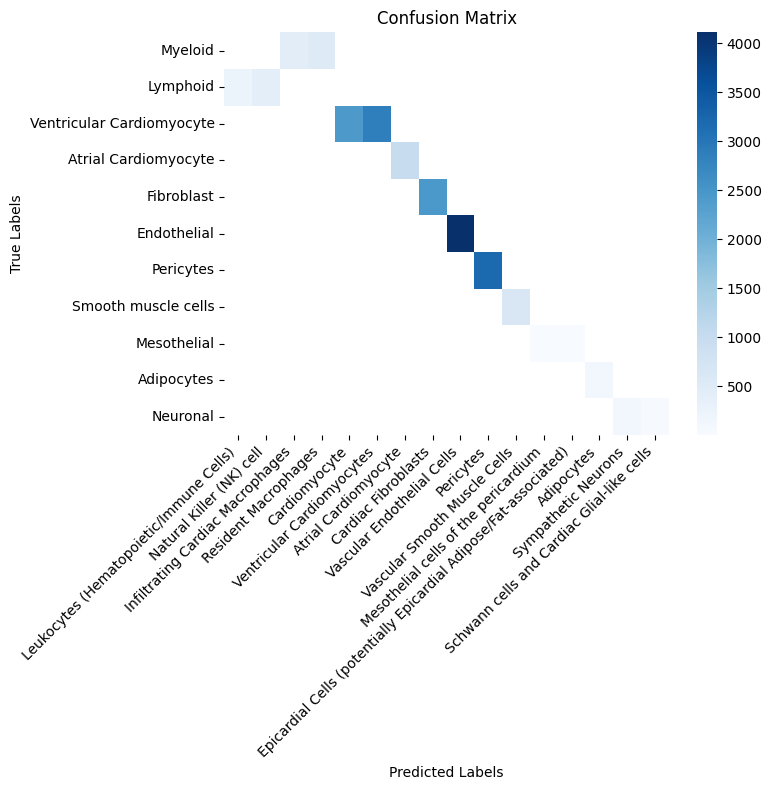

In [10]:
df = adata.obs.groupby(["cell_type", "cell_type_predicted"], observed=True).size().unstack()

# Plot the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(df, annot=False, cmap="Blues", xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Note that your results might look slightly different, but we have found the the model behaves mostly robust and many variations are synonyms or closely related cell types. We can also compare ground-truth and predicted cell types in the UMAP embedding. 

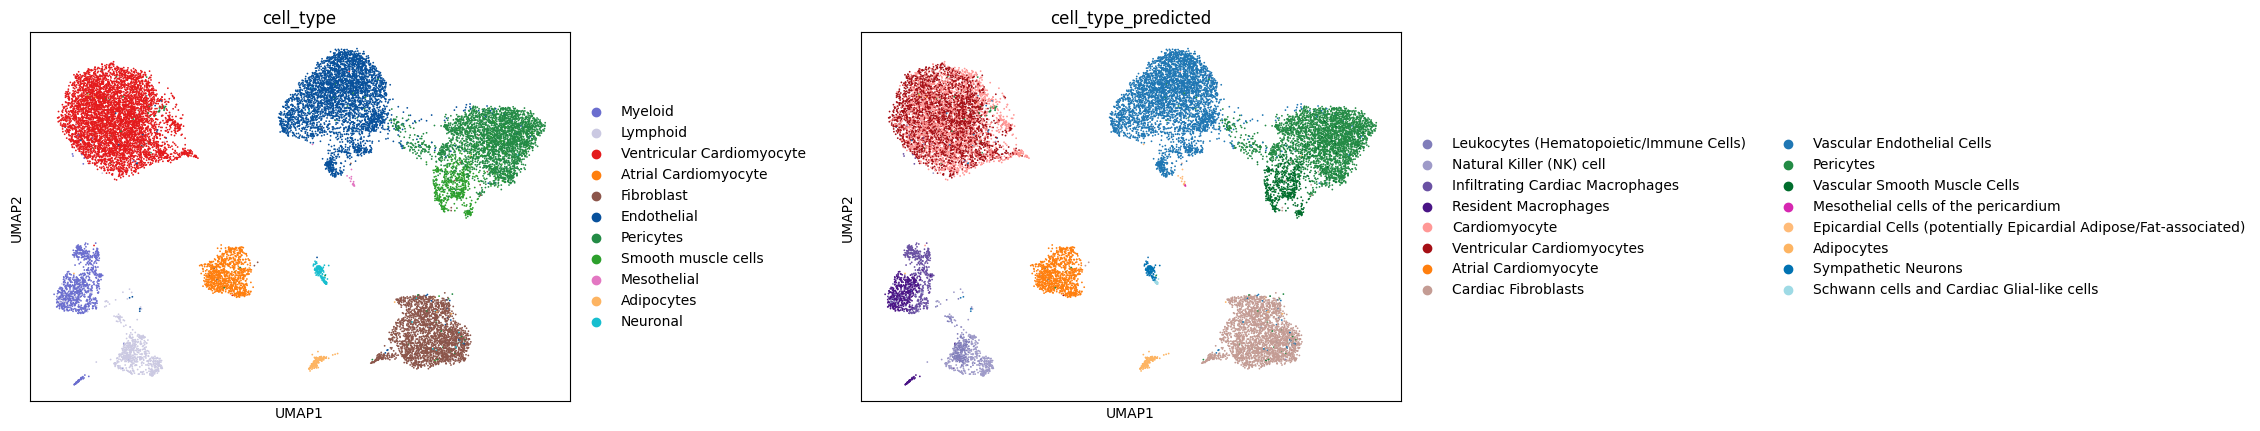

In [11]:
sc.pl.embedding(adata, basis="umap", color=["cell_type", "cell_type_predicted"], wspace=0.4, ncols=5)

Colors have been assigned automatically and should ideally be comparable across the two annotations. 